# Aprendizaje Automatico - TP 1 : Prueba de sanidad

A modo de validar que no todos los modelos funcionen como deben, no demoren una cantidad extraordinaria de tiempo ni invertamos tiempo entrendando modelos que no tienen para nada buena performance, realizamos cross-validation sobre un subconjunto del dataset de entrenamiento

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:g}'.format
plt.rcParams['figure.figsize'] = 14, 5

from scripts.util import *
from scripts.builders import *

In [2]:
train_set, test_set = load_processed_data()
print ''
print_sets_summarys(train_set, test_set)

Loading Train Set
Done in 1.000000s

Loading Test Set
Done in 0.238000s

Train Set: 72000 samples - ham: 35997(0.50%) spam: 36003(0.50%)
Test Set:  18000 samples - ham: 9003(0.50%) spam: 8997(0.50%)


In [3]:
pipeline_types = [None, 'tfidf', 'k_best', 'l1', 'pca']
classifier_types = ['dt', 'random_forest', 'bernoulli_nb', 'multinomial_nb', 'knn', 'svm']
pipelines = build_all_pipelines(pipeline_types, pipeline_types, classifier_types)

In [4]:
scores, cv_times = evaluate_and_measure(train_set.sample(10000), pipelines, 'sanity', cv=10, n_jobs=5)

Loading scores from results/sanity_scores.pkl
Done in 0.054000s
Loading cv_times from results/sanity_cv_times.pkl
Done in 0.000000s



In [5]:
def build_summary_dataframe(pipelines, scores, cv_times):
    names = [name for name, _, _ in pipelines]

    df = pd.DataFrame(index=names, columns=['mean_cv_score', 'runtime'])

    df.mean_cv_score = [np.mean(scores[name]) for name in names]
    df.runtime = [cv_times[name] for name in names]
    
    df['simple_features'] = [configuration['simple_features'] for _, configuration, _ in pipelines]
    df['subject_pipeline'] = [configuration['subject_pipeline_type'] for _, configuration, _ in pipelines]
    df['body_pipeline'] = [configuration['body_pipeline_type'] for _, configuration, _ in pipelines]
    df['classifier'] = [configuration['classifier_type'] for _, configuration, _ in pipelines]

    return df

In [6]:
summary_df = build_summary_dataframe(pipelines, scores, cv_times)

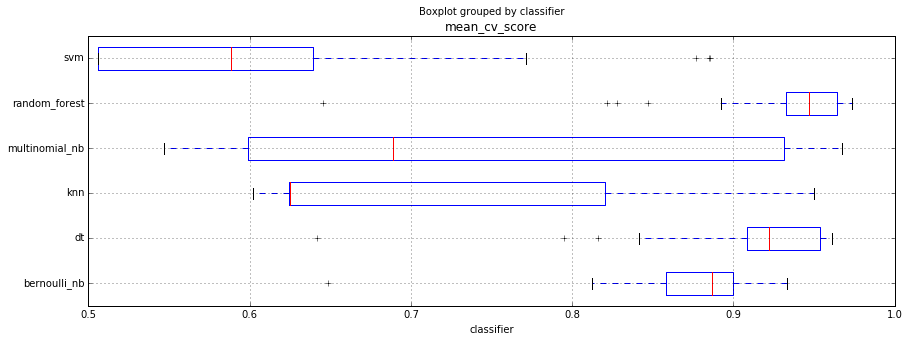

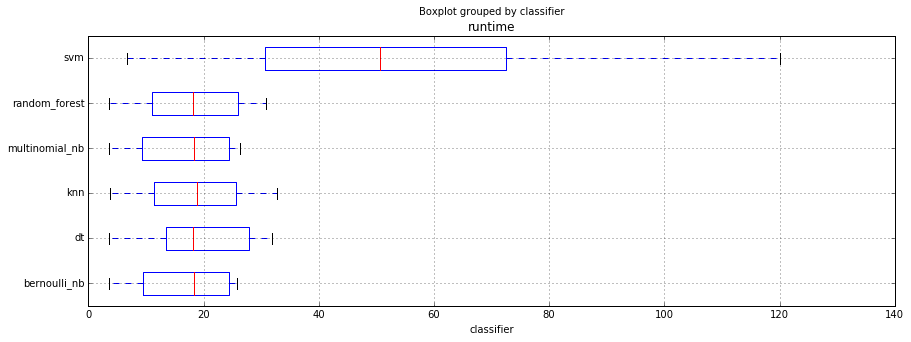

In [7]:
summary_df.boxplot(column=['mean_cv_score'], by='classifier', vert=False)
summary_df.boxplot(column=['runtime'], by='classifier', vert=False)

Vemos que SVM tiene muy mal rendimiento tanto en puntaje de CV como en tiempo de ejecución, por lo que decidimos removerlo de los clasificadores a probar con el set completo.

Veamos en mas detalle que sucede con KNN y MultiniomalNB, ya que tienen una gran varianza

In [8]:
summary_df[summary_df['classifier'] == 'multinomial_nb'].sort_values(by='mean_cv_score', ascending=False).head(10)

,mean_cv_score,runtime,simple_features,subject_pipeline,body_pipeline,classifier
subject_l1__body_tfidf__multinomial_nb,0.9676,9.488,False,l1,tfidf,multinomial_nb
subject_tfidf__body_tfidf__multinomial_nb,0.963801,9.322,False,tfidf,tfidf,multinomial_nb
subject_l1__body_l1__multinomial_nb,0.959201,11.117,False,l1,l1,multinomial_nb
subject_k_best__body_tfidf__multinomial_nb,0.9562,9.36,False,k_best,tfidf,multinomial_nb
subject_k_best__body_l1__multinomial_nb,0.952901,11.048,False,k_best,l1,multinomial_nb
body_tfidf__multinomial_nb,0.950099,8.987,False,None,tfidf,multinomial_nb
body_l1__multinomial_nb,0.949901,10.676,False,None,l1,multinomial_nb
subject_tfidf__body_l1__multinomial_nb,0.9488,11.043,False,tfidf,l1,multinomial_nb
subject_l1__body_k_best__multinomial_nb,0.913399,9.56,False,l1,k_best,multinomial_nb
subject_tfidf__body_k_best__multinomial_nb,0.887702,9.34,False,tfidf,k_best,multinomial_nb


In [9]:
summary_df[summary_df['classifier'] == 'multinomial_nb'].sort_values(by='mean_cv_score', ascending=False).tail(5)

,mean_cv_score,runtime,simple_features,subject_pipeline,body_pipeline,classifier
simple_features__subject_tfidf__multinomial_nb,0.578,18.413,True,tfidf,None,multinomial_nb
simple_features__subject_l1__multinomial_nb,0.5677,18.545,True,l1,None,multinomial_nb
simple_features__body_k_best__multinomial_nb,0.565,24.586,True,None,k_best,multinomial_nb
simple_features__subject_k_best__multinomial_nb,0.551401,18.337,True,k_best,None,multinomial_nb
simple_features__multinomial_nb,0.5469,18.794,True,None,None,multinomial_nb


In [10]:
summary_df[summary_df['classifier'] == 'knn'].sort_values(by='mean_cv_score', ascending=False).head(10)

,mean_cv_score,runtime,simple_features,subject_pipeline,body_pipeline,classifier
subject_pca__body_pca__knn,0.949902,18.157,False,pca,pca,knn
subject_k_best__body_pca__knn,0.943802,18.387,False,k_best,pca,knn
body_pca__knn,0.940699,16.35,False,None,pca,knn
subject_l1__body_pca__knn,0.916199,18.684,False,l1,pca,knn
subject_tfidf__body_pca__knn,0.907301,18.566,False,tfidf,pca,knn
subject_pca__body_k_best__knn,0.9013,12.015,False,pca,k_best,knn
subject_l1__body_k_best__knn,0.877998,10.085,False,l1,k_best,knn
body_k_best__knn,0.876318,9.62,False,None,k_best,knn
subject_tfidf__body_k_best__knn,0.875802,9.987,False,tfidf,k_best,knn
subject_k_best__body_k_best__knn,0.874212,9.922,False,k_best,k_best,knn


In [11]:
summary_df[summary_df['classifier'] == 'knn'].sort_values(by='mean_cv_score', ascending=False).tail(5)

,mean_cv_score,runtime,simple_features,subject_pipeline,body_pipeline,classifier
simple_features__body_k_best__knn,0.623902,24.827,True,None,k_best,knn
simple_features__subject_l1__body_k_best__knn,0.623602,25.233,True,l1,k_best,knn
simple_features__subject_l1__knn,0.623402,19.449,True,l1,None,knn
simple_features__subject_l1__body_l1__knn,0.623402,26.513,True,l1,l1,knn
subject_k_best__knn,0.602221,3.822,False,k_best,None,knn


In [12]:
summary_df[summary_df['classifier'] == 'multinomial_nb'].groupby('simple_features').describe()

mean_cv_score  runtime
simple_features                              
False           count             15       15
                mean        0.899181   8.6302
                std        0.0852821  2.68651
                min           0.6479    3.587
                25%         0.861851    9.078
                50%           0.9488     9.36
                75%          0.95455   10.118
                max           0.9676   11.117
True            count             16       16
                mean          0.6115  23.3762
                std        0.0502148  2.98086
                min           0.5469   18.337
                25%         0.575425   22.808
                50%         0.598701    24.36
                75%           0.6386  25.5588
                max         0.710799   26.393

In [13]:
summary_df[summary_df['classifier'] == 'knn'].groupby('simple_features').describe()

mean_cv_score  runtime
simple_features                              
False           count             24       24
                mean         0.81806  11.2627
                std         0.101263  4.52287
                min         0.602221    3.822
                25%         0.782303  9.91825
                50%         0.827101  11.0025
                75%         0.883823  12.5108
                max         0.949902   18.684
True            count             25       25
                mean         0.62455  25.8234
                std      0.000635783  4.01677
                min         0.623402   18.791
                25%         0.624102   24.902
                50%         0.624602   25.565
                75%         0.625102    27.61
                max         0.625402   32.736

Vemos que en ambos casos, la presencia de los atributos simples parecieran generar ruido, por lo que en la evaluacion con el set completo removeremos los pipelines que tengan simple_features y como clasificador KNN o MultinomialNB.